# 少数クラスデータの影響、データ増強、Oversamplingの比較

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import tensorboard as tb
import numpy as np

In [2]:
def calc_mean_f1_score(df):
    """ f1 score calculator """
    class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
    f1_mean_map = {}
    for cls_nm in class_names:
        f1_scores = []
        for fold_idx in range(5):
            f1 = df.loc[df["run"]==f"valid_fold{fold_idx+1}_f1-score_{cls_nm}"].sort_values(by=["step"], ascending=False)["value"].iloc[0]
            f1_scores.append(np.round(f1, 2))
        f1_mean_map[cls_nm] = np.mean(f1_scores)
    return f1_mean_map

In [3]:
def calc_mean_acc_score(df):
    acc_scores = []
    for fold_idx in range(5):
        acc = df.loc[df["run"]==f"valid_acc_fold{fold_idx+1}"].sort_values(by=["step"], ascending=False)["value"].iloc[0]
        acc_scores.append(acc)
    return np.mean(acc_scores)

# 不均衡データ vs 均衡データ

不均衡データ

In [4]:
# read results from tensorboard
experiment_id = "BX5GjbzkQKaXrE2xHwYAYw"
experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
df_imb = experiment.get_scalars()

f1_mean_map_imbalance = calc_mean_f1_score(df_imb)

均衡データ

In [5]:
# read results from tensorboard
experiment_id = "onhNEOULQuOefRFrlHY37g"
experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
df_blc = experiment.get_scalars()

# calc f1 score
f1_mean_map_balanced = calc_mean_f1_score(df_blc)

F1スコアのランク比較

In [6]:
df_f1_comp = pd.DataFrame([f1_mean_map_imbalance, f1_mean_map_balanced], index=["Imbalance", "Balanced"])
summary_rank = df_f1_comp.rank(axis=1, ascending=False)
summary_rank.index = ["Imbalanced (rank)", "Balanced (rank)"]
summary_rank

,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
Imbalanced (rank),5.0,1.0,10.0,9.0,8.0,7.0,3.0,4.0,2.0,6.0
Balanced (rank),6.0,2.0,8.0,10.0,7.0,9.0,4.0,5.0,1.0,3.0


- 少数クラスのうちbirdとdeerは、他クラスのデータ量が2500と均衡しても順位はほぼ最下位のまま→CNNにとって元々分類の苦手なクラス
- 少数クラスのうちtruckは、他クラスのデータ量が2500と均衡したことで順位が6位から3位へ浮上→CNNにとって分類の得意なクラス

F1スコア比較

In [7]:
summary_f1 = pd.concat([df_f1_comp, pd.DataFrame(df_f1_comp.loc["Balanced", :] - df_f1_comp.loc["Imbalance", :]).transpose()], axis=0)
summary_f1.index = ["Imbalanced (f1)", "Balanced (f1)", "Diff"]
summary_f1

,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
Imbalanced (f1),0.746,0.830,0.484,0.538,0.558,0.612,0.78,0.762,0.810,0.708
Balanced (f1),0.694,0.778,0.560,0.474,0.616,0.550,0.75,0.704,0.782,0.760
Diff,-0.052,-0.052,0.076,-0.064,0.058,-0.062,-0.03,-0.058,-0.028,0.052


- 均衡データセットになったことでデータ量が減ったクラスはF1スコアも減少（bird, deer, truck以外のクラス）

Validation acc

In [8]:
calc_mean_acc_score(df_imb)

0.7010117530822754

In [9]:
calc_mean_acc_score(df_blc)

0.6676800131797791

# No Aug vs Aug

In [10]:
# read results from tensorboard
experiment_id = "BX5GjbzkQKaXrE2xHwYAYw"
experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
df_no_aug = experiment.get_scalars()

In [11]:
# read results from tensorboard
experiment_id = "qOPbJVEwQf6zbkLNP4Dxiw"
experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
df_aug = experiment.get_scalars()

In [12]:
f1_mean_map_no_aug = calc_mean_f1_score(df_no_aug)
f1_mean_map_aug = calc_mean_f1_score(df_aug)
df_f1_comp_aug = pd.DataFrame([f1_mean_map_no_aug, f1_mean_map_aug], index=["No Aug", "Aug"])
summary_f1_aug = pd.concat([df_f1_comp_aug, pd.DataFrame(df_f1_comp_aug.loc["Aug", :] - df_f1_comp_aug.loc["No Aug", :]).transpose()], axis=0)
summary_f1_aug.index = ["No Aug", "Aug", "Improvement"]
summary_f1_aug

,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
No Aug,0.746,0.830,0.484,0.538,0.558,0.612,0.78,0.762,0.810,0.708
Aug,0.792,0.856,0.542,0.576,0.586,0.666,0.78,0.796,0.846,0.724
Improvement,0.046,0.026,0.058,0.038,0.028,0.054,0.00,0.034,0.036,0.016


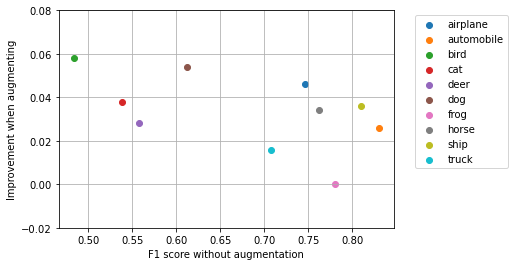

In [13]:
from matplotlib import pyplot as plt
for label in f1_mean_map_aug.keys():
    plt.scatter(x=summary_f1_aug.loc["No Aug", label], y=summary_f1_aug.loc["Improvement", label], label=label)
plt.xlabel("F1 score without augmentation")
plt.ylabel("Improvement when augmenting")
plt.grid()
plt.ylim([-0.02, 0.08])
plt.legend(bbox_to_anchor=(1.05, 1))
plt.savefig("./scatter_improve_aug.png", bbox_inches="tight")

In [21]:
# valid acc aug with oversampling
calc_mean_acc_score(df_aug)

0.7420235276222229

# Aug vs Aug with oversampling

In [14]:
# read results from tensorboard
experiment_id = "qOPbJVEwQf6zbkLNP4Dxiw"
experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
df_aug = experiment.get_scalars()

In [15]:
# read results from tensorboard
experiment_id = "clKHr7h1Q8WArvq8VTNNqg"
experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
df_aug_ovsample = experiment.get_scalars()

In [16]:
f1_mean_map_aug = calc_mean_f1_score(df_aug)
f1_mean_map_aug_ovsample = calc_mean_f1_score(df_aug_ovsample)
df_f1_comp_os = pd.DataFrame([f1_mean_map_aug, f1_mean_map_aug_ovsample], index=["Aug", "Aug+Oversample"])
summary_f1_os = pd.concat([df_f1_comp_os, pd.DataFrame(df_f1_comp_os.loc["Aug+Oversample", :] - df_f1_comp_os.loc["Aug", :]).transpose()], axis=0)
summary_f1_os.index = ["Aug", "Aug+Oversample", "Improvement"]
summary_f1_os

,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
Aug,0.792,0.856,0.542,0.576,0.586,0.666,0.780,0.796,0.846,0.724
Aug+Oversample,0.786,0.862,0.586,0.564,0.648,0.664,0.784,0.808,0.846,0.698
Improvement,-0.006,0.006,0.044,-0.012,0.062,-0.002,0.004,0.012,0.000,-0.026


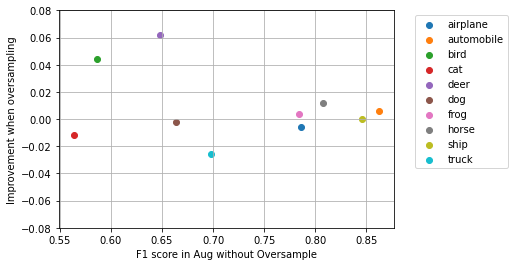

In [17]:
from matplotlib import pyplot as plt
for label in f1_mean_map_aug.keys():
    plt.scatter(x=summary_f1_os.loc["Aug+Oversample", label], y=summary_f1_os.loc["Improvement", label], label=label)
plt.xlabel("F1 score in Aug without Oversample")
plt.ylabel("Improvement when oversampling")
plt.grid()
plt.ylim([-0.08, 0.08])
plt.legend(bbox_to_anchor=(1.05, 1))
plt.savefig("./scatter_improve_os.png", bbox_inches="tight")

In [18]:
# valid acc aug with oversampling
calc_mean_acc_score(df_aug_ovsample)

0.7431764602661133

# Test Acc in aug + oversampling

In [19]:
# read results from tensorboard
experiment_id = "qxAAgHKrQqOGTzEEJQlGBg"
experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
df_aug_ovsample_test = experiment.get_scalars()

In [20]:
df_aug_ovsample_test.loc[df_aug_ovsample_test["run"]==f"valid_acc_fold1"].sort_values(by=["step"], ascending=False)["value"].iloc[0]

0.7052000164985657